In [1]:
import pandas as pd
import numpy as np  
import re
from nltk.corpus import stopwords
from numpy import array 


from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Dense
from sklearn.model_selection import train_test_split

2024-08-15 14:32:52.731367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:32:52.737712: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:32:52.755770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 14:32:52.784877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 14:32:52.793250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 14:32:52.813700: I tensorflow/core/platform/cpu_feature_gu

In [2]:
news = pd.read_csv("Airline-Sentiment-2-w-AA.csv", encoding="ISO-8859-1")
news.shape

(14640, 20)

In [3]:
news.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


<Axes: xlabel='airline_sentiment', ylabel='count'>

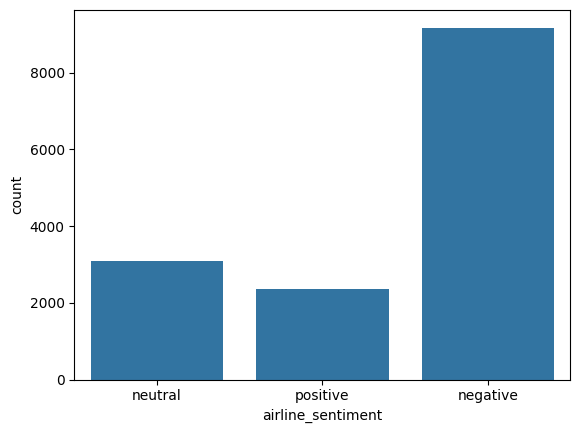

In [5]:
import seaborn as sns
sns.countplot(x='airline_sentiment', data=news)

In [6]:
news["text"][0]

'@VirginAmerica What @dhepburn said.'

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [10]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(news["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
X[0]

' virginamerica dhepburn said '

In [12]:
# Converting sentiment labels to 0 to netutral, -1 negative, 1 positive

y = news['airline_sentiment']

y = np.array(list(map(lambda x: -1 if x== "negative" else 1 if x == "positive" else 0, y)))

print(y[0], y[1], y[3])

0 1 -1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.8, random_state=23)

In [14]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

11914

In [16]:

X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

In [17]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
embedding_matrix.shape

(11914, 100)

## Recurrent Neural Network (LSTM)

In [20]:
from keras.layers import LSTM

In [21]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix],  input_length=100, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

/home/zaz/Documents/uni/tesis/tprototype/back/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1723754002.161910   24708 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-15 14:33:22.163094: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,191,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191,400 (4.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,191,400 (4.54 MB)

None


In [23]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

Epoch 1/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - acc: 0.2032 - loss: -3.7118 - val_acc: 0.2211 - val_loss: -10.2088
Epoch 2/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.2088 - loss: -12.0273 - val_acc: 0.2211 - val_loss: -14.9264
Epoch 3/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2083 - loss: -17.0211 - val_acc: 0.2211 - val_loss: -19.3574
Epoch 4/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.2107 - loss: -21.3935 - val_acc: 0.2211 - val_loss: -23.7000
Epoch 5/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2088 - loss: -26.4924 - val_acc: 0.2211 - val_loss: -28.0347
Epoch 6/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2088 - loss: -31.5020 - val_acc: 0.2211 - val_loss: -32.3952
Epoch 7/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2161 - loss: -35.6495 - val_acc: 0.2211 - val_loss: -36.6631
Epoch 8/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2086 - loss: -40.3091 - val_acc: 0.2211 - val_loss: -40.9770


In [24]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.2093 - loss: -40.2699


In [25]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -40.87656021118164
Test Accuracy: 0.20765027403831482


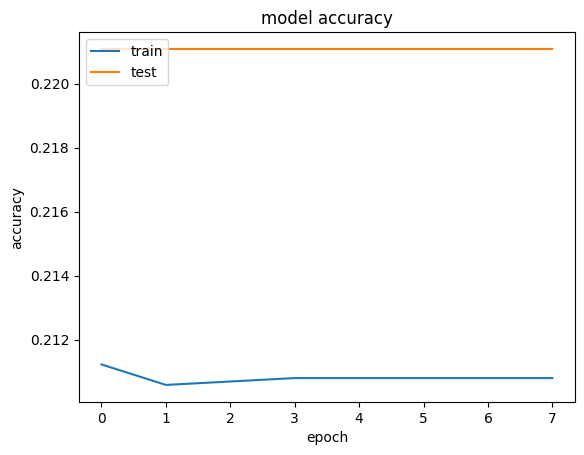

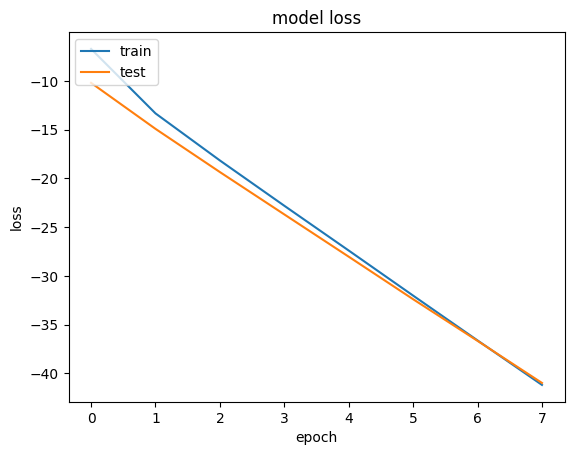

In [26]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()